# PARTICLE FILTERING INTENTION INFERENCE

MULTI-MODE AGENT DEMONSTRATION

1. Comparing all three reference path modes:


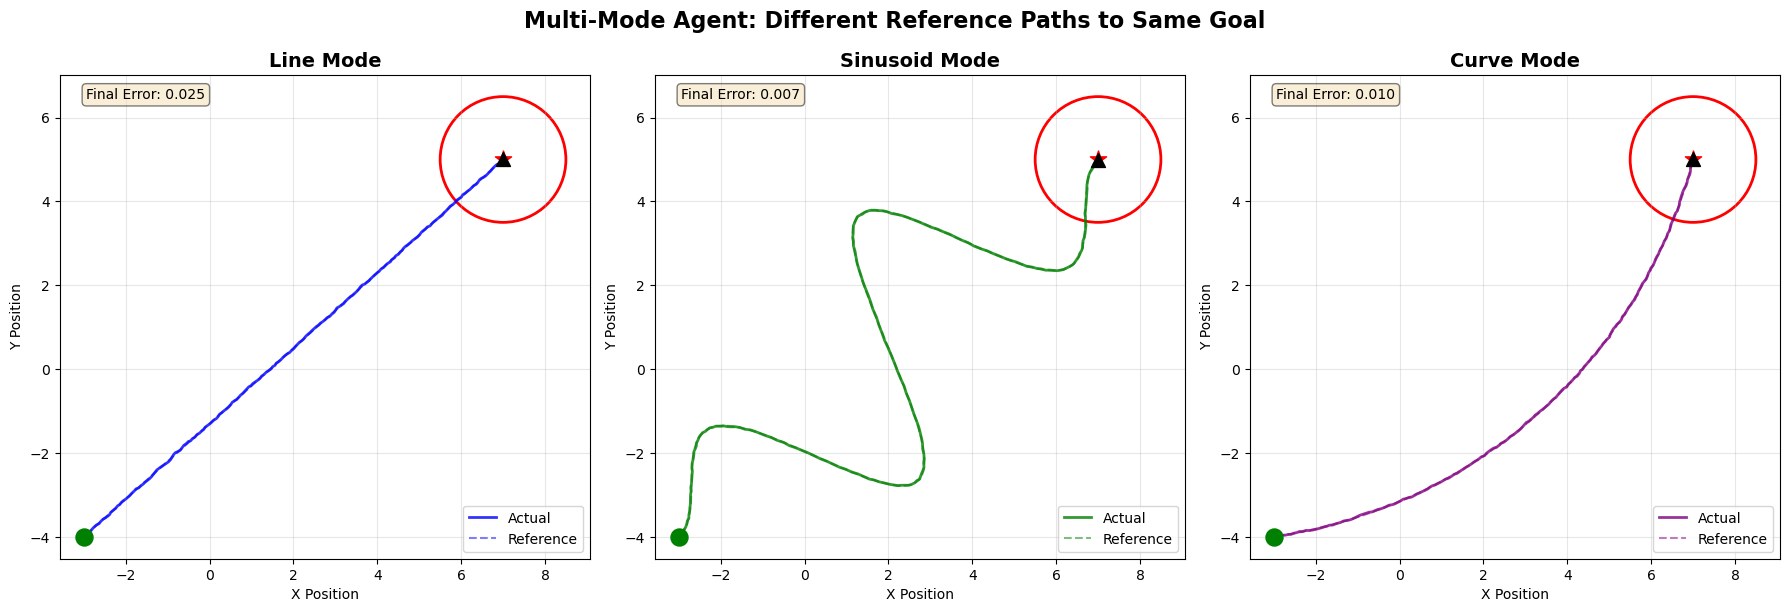


2. Detailed trajectory for sinusoid mode:


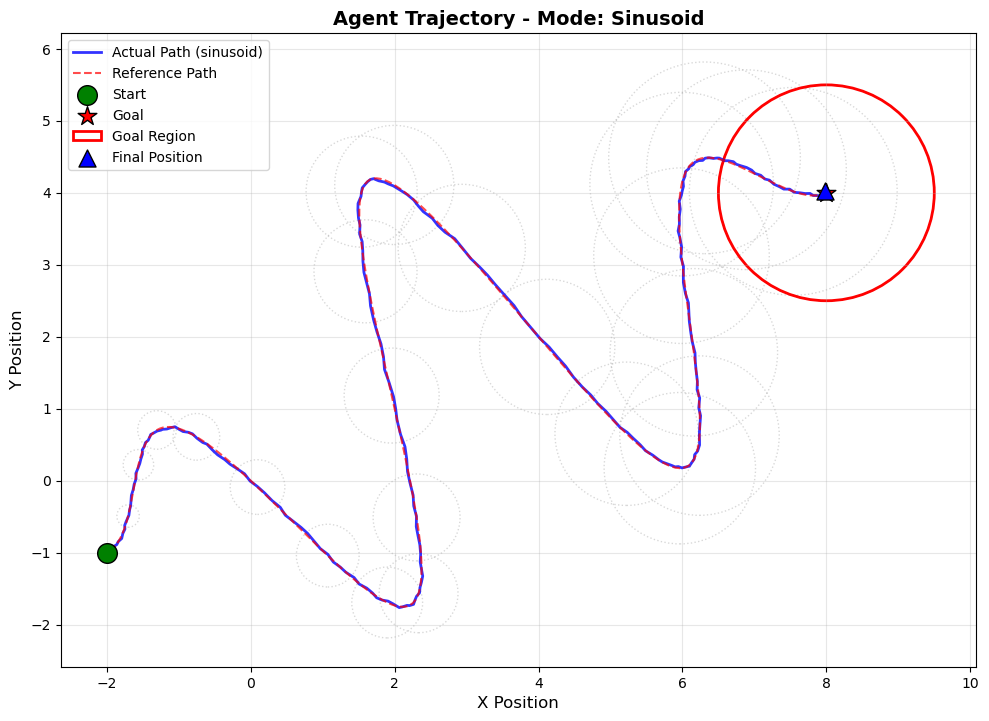


Trajectory Statistics (sinusoid mode):
  Final time: 30.00s / Goal time: 25.00s
  Final error: 0.030 / Goal radius: 1.500
  Success: True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from typing import Literal, Optional, Tuple

class MultiModeAgent:
    """
    Agent with three different reference path modes that all guarantee
    reaching the goal region x(θ) + r(θ)B within time t(θ)
    
    Modes:
    - 'line': Straight line path (original)
    - 'sinusoid': Sinusoidal deviation from straight path
    - 'curve': Large curved arc path
    """
    
    def __init__(self, 
                 theta_com: np.ndarray,  # [x_goal, y_goal, r_goal, t_goal]
                 x0: np.ndarray,          # Initial position
                 mode: Literal['line', 'sinusoid', 'curve'] = 'line',
                 d_bar: float = 0.2,      # Disturbance bound
                 dt: float = 0.1,         # Time step
                 amplitude: float = 2.0,  # Amplitude for sinusoid/curve modes
                 frequency: float = 2.0): # Frequency for sinusoid mode
        """
        Initialize agent with specified reference path mode
        
        Args:
            theta_com: Intent parameter [x_goal, y_goal, r_goal, t_goal]
            x0: Initial position
            mode: Reference path type ('line', 'sinusoid', 'curve')
            d_bar: Disturbance bound
            dt: Time step
            amplitude: Controls deviation magnitude for non-line modes
            frequency: Controls oscillation frequency for sinusoid mode
        """
        
        self.theta_com = theta_com
        self.x_goal = theta_com[:2]
        self.r_goal = theta_com[2]
        self.t_goal = theta_com[3]
        self.x0 = x0
        self.mode = mode
        self.d_bar = d_bar
        self.dt = dt
        self.amplitude = amplitude
        self.frequency = frequency
        
        # Current state
        self.x = x0.copy()
        self.time = 0
        
        # Trajectory storage
        self.trajectory = [x0.copy()]
        self.reference_trajectory = []
        
        # Compute path parameters based on mode
        self._setup_path_parameters()
        
    def _setup_path_parameters(self):
        """
        Setup parameters specific to each path mode
        """
        # Vector from start to goal
        self.delta = self.x_goal - self.x0
        self.distance = np.linalg.norm(self.delta)
        
        if self.distance > 0:
            self.direction = self.delta / self.distance
            # Perpendicular direction for lateral deviations
            self.perp_direction = np.array([-self.direction[1], self.direction[0]])
        else:
            self.direction = np.array([1.0, 0.0])
            self.perp_direction = np.array([0.0, 1.0])
        
        # Mode-specific setup
        if self.mode == 'curve':
            # For curve mode, compute arc parameters
            # We'll use a circular arc that passes through start and end
            self._setup_curve_parameters()
            
    def _setup_curve_parameters(self):
        """
        Setup parameters for curved arc path
        Creates a circular arc from x0 to x_goal
        """
        # Midpoint between start and goal
        midpoint = (self.x0 + self.x_goal) / 2
        
        # The arc center is offset perpendicular to the line
        # Offset determines curvature (larger = more curved)
        offset_distance = self.amplitude * self.distance / 4
        self.arc_center = midpoint + self.perp_direction * offset_distance
        
        # Radius of the arc
        self.arc_radius = np.linalg.norm(self.x0 - self.arc_center)
        
        # Start and end angles
        vec_start = self.x0 - self.arc_center
        vec_end = self.x_goal - self.arc_center
        self.angle_start = np.arctan2(vec_start[1], vec_start[0])
        self.angle_end = np.arctan2(vec_end[1], vec_end[0])
        
        # Ensure we take the shorter arc
        angle_diff = self.angle_end - self.angle_start
        if angle_diff > np.pi:
            angle_diff -= 2 * np.pi
        elif angle_diff < -np.pi:
            angle_diff += 2 * np.pi
        self.angle_span = angle_diff
        
    def reference_path(self, t: float) -> np.ndarray:
        """
        Compute reference position at time t based on selected mode
        All modes guarantee reaching x_goal at t_goal
        
        Args:
            t: Current time
            
        Returns:
            Reference position at time t
        """
        # Clamp time to [0, t_goal]
        t = np.clip(t, 0, self.t_goal)
        
        # Progress parameter s ∈ [0, 1]
        s = t / self.t_goal if self.t_goal > 0 else 1.0
        
        if self.mode == 'line':
            # Straight line path (equation 10 from paper)
            return self.x0 + s * self.delta
            
        elif self.mode == 'sinusoid':
            # Sinusoidal deviation from straight path
            # Progress along main direction
            main_progress = self.x0 + s * self.delta
            
            # Lateral sinusoidal deviation that starts and ends at 0
            lateral_deviation = self.amplitude * np.sin(2 * np.pi * self.frequency * s)
            lateral_deviation *= (1 - s) * s * 4  # Envelope to ensure start/end at 0
            
            return main_progress + lateral_deviation * self.perp_direction
            
        elif self.mode == 'curve':
            # Curved arc path
            if self.distance < 0.01:  # If start ≈ goal
                return self.x_goal
                
            # Interpolate angle along the arc
            current_angle = self.angle_start + s * self.angle_span
            
            # Position on the arc
            x_ref = self.arc_center[0] + self.arc_radius * np.cos(current_angle)
            y_ref = self.arc_center[1] + self.arc_radius * np.sin(current_angle)
            
            return np.array([x_ref, y_ref])
            
        else:
            raise ValueError(f"Unknown mode: {self.mode}")
    
    def get_envelope_radius(self, t: float) -> float:
        """
        Get the tracking error envelope ρ(t) at time t
        Grows from small value to r_goal over time
        
        Args:
            t: Current time
            
        Returns:
            Allowed tracking error radius at time t
        """
        if t >= self.t_goal:
            return self.r_goal
        
        # Linear growth from 0.1 to r_goal
        rho_min = 0.1
        return rho_min + (self.r_goal - rho_min) * (t / self.t_goal)
    
    def compute_control(self) -> np.ndarray:
        """
        Compute control input to track reference path
        
        Returns:
            Control input u
        """
        # Current reference position
        x_ref = self.reference_path(self.time)
        
        # Tracking error
        error = self.x - x_ref
        error_norm = np.linalg.norm(error)
        
        # Current envelope constraint
        rho = self.get_envelope_radius(self.time)
        
        # Adaptive control gain based on error magnitude
        if error_norm > 0.8 * rho:
            # Strong correction when approaching envelope boundary
            k_gain = 10.0
        else:
            # Normal tracking gain
            k_gain = 5.0
        
        # Feedback control to track reference
        u = -k_gain * error
        
        # Optional: Add feedforward term for better tracking
        if self.time + self.dt <= self.t_goal:
            # Approximate reference velocity
            x_ref_next = self.reference_path(self.time + self.dt)
            v_ref = (x_ref_next - x_ref) / self.dt
            u += 0.5 * v_ref  # Feedforward component
        
        return u
    
    def step(self) -> np.ndarray:
        """
        Execute one time step of agent dynamics
        
        Returns:
            Current position after step
        """
        # Get control input
        u = self.compute_control()
        
        # Add bounded disturbance
        disturbance = self.d_bar * (2 * np.random.rand(2) - 1)
        
        # Update state (equation 1 from paper)
        self.x = self.x + self.dt * (u + disturbance)
        
        # Update time
        self.time += self.dt
        
        # Store trajectory
        self.trajectory.append(self.x.copy())
        self.reference_trajectory.append(self.reference_path(self.time))
        
        return self.x.copy()
    
    def run_full_trajectory(self, T: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Run agent for T time steps or until t_goal
        
        Args:
            T: Number of time steps (if None, runs until 1.2 * t_goal)
            
        Returns:
            Tuple of (actual_trajectory, reference_trajectory)
        """
        if T is None:
            T = int(1.2 * self.t_goal / self.dt)
        
        for _ in range(T):
            self.step()
        
        return np.array(self.trajectory), np.array(self.reference_trajectory)
    
    def plot_trajectory(self, show_reference: bool = True, 
                       show_envelope: bool = True,
                       title: Optional[str] = None):
        """
        Plot the agent's trajectory and goal
        
        Args:
            show_reference: Whether to show reference trajectory
            show_envelope: Whether to show tracking envelope
            title: Plot title
        """
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Convert trajectories to arrays
        traj = np.array(self.trajectory)
        ref_traj = np.array(self.reference_trajectory) if self.reference_trajectory else None
        
        # Plot actual trajectory
        ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2, 
                label=f'Actual Path ({self.mode})', alpha=0.8)
        
        # Plot reference trajectory
        if show_reference and ref_traj is not None:
            ax.plot(ref_traj[:, 0], ref_traj[:, 1], 'r--', linewidth=1.5,
                    label='Reference Path', alpha=0.7)
        
        # Plot tracking envelope along reference path
        if show_envelope and ref_traj is not None:
            for i in range(0, len(ref_traj), 10):
                t = i * self.dt
                rho = self.get_envelope_radius(t)
                circle = Circle(ref_traj[i], rho, fill=False, 
                              edgecolor='gray', alpha=0.3, linestyle=':')
                ax.add_patch(circle)
        
        # Mark start position
        ax.scatter(self.x0[0], self.x0[1], c='green', s=200, 
                  marker='o', label='Start', zorder=5, edgecolors='black')
        
        # Mark goal position and region
        ax.scatter(self.x_goal[0], self.x_goal[1], c='red', s=200,
                  marker='*', label='Goal', zorder=5, edgecolors='black')
        
        # Goal region
        goal_circle = Circle(self.x_goal, self.r_goal, fill=False,
                           edgecolor='red', linewidth=2, label='Goal Region')
        ax.add_patch(goal_circle)
        
        # Mark final position
        ax.scatter(traj[-1, 0], traj[-1, 1], c='blue', s=150,
                  marker='^', label='Final Position', zorder=5, edgecolors='black')
        
        # Formatting
        ax.set_xlabel('X Position', fontsize=12)
        ax.set_ylabel('Y Position', fontsize=12)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        
        if title is None:
            title = f'Agent Trajectory - Mode: {self.mode.capitalize()}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print final statistics
        final_error = np.linalg.norm(self.x - self.x_goal)
        print(f"\nTrajectory Statistics ({self.mode} mode):")
        print(f"  Final time: {self.time:.2f}s / Goal time: {self.t_goal:.2f}s")
        print(f"  Final error: {final_error:.3f} / Goal radius: {self.r_goal:.3f}")
        print(f"  Success: {final_error <= self.r_goal}")


def demo_all_modes():
    """
    Demonstrate all three reference path modes
    """
    # Common parameters
    theta_com = np.array([7.0, 5.0, 1.5, 20.0])  # [x, y, r, t]
    x0 = np.array([-3.0, -4.0])
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    modes = ['line', 'sinusoid', 'curve']
    colors = ['blue', 'green', 'purple']
    
    for idx, (mode, color, ax) in enumerate(zip(modes, colors, axes)):
        # Create agent with specified mode
        agent = MultiModeAgent(
            theta_com=theta_com,
            x0=x0,
            mode=mode,
            d_bar=0.15,
            amplitude=3.0 if mode != 'line' else 0,
            frequency=2.0
        )
        
        # Run simulation
        T = int(1.2 * theta_com[3] / agent.dt)
        actual_traj, ref_traj = agent.run_full_trajectory(T)
        
        # Plot on subplot
        ax.plot(actual_traj[:, 0], actual_traj[:, 1], 
                color=color, linewidth=2, label='Actual', alpha=0.8)
        ax.plot(ref_traj[:, 0], ref_traj[:, 1], 
                color=color, linestyle='--', linewidth=1.5, 
                label='Reference', alpha=0.5)
        
        # Start and goal
        ax.scatter(x0[0], x0[1], c='green', s=150, marker='o', zorder=5)
        ax.scatter(theta_com[0], theta_com[1], c='red', s=150, marker='*', zorder=5)
        
        # Goal region
        circle = Circle(theta_com[:2], theta_com[2], fill=False,
                       edgecolor='red', linewidth=2)
        ax.add_patch(circle)
        
        # Final position
        ax.scatter(actual_traj[-1, 0], actual_traj[-1, 1], 
                  c='black', s=100, marker='^', zorder=5)
        
        # Formatting
        ax.set_title(f'{mode.capitalize()} Mode', fontsize=14, fontweight='bold')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        
        # Calculate final error
        final_error = np.linalg.norm(actual_traj[-1] - theta_com[:2])
        ax.text(0.05, 0.95, f'Final Error: {final_error:.3f}',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Multi-Mode Agent: Different Reference Paths to Same Goal', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    print("=" * 60)
    print("MULTI-MODE AGENT DEMONSTRATION")
    print("=" * 60)
    
    # Demo 1: Show all three modes side by side
    print("\n1. Comparing all three reference path modes:")
    demo_all_modes()
    
    # Demo 2: Detailed single mode example
    print("\n2. Detailed trajectory for sinusoid mode:")
    theta = np.array([8.0, 4.0, 1.5, 25.0])
    x0 = np.array([-2.0, -1.0])
    
    agent = MultiModeAgent(
        theta_com=theta,
        x0=x0,
        mode='sinusoid',
        d_bar=0.2,
        amplitude=3.0,
        frequency=2.5
    )
    
    agent.run_full_trajectory()
    agent.plot_trajectory(show_reference=True, show_envelope=True)

# old agent, Dont run

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Import the corrected RBPF implementation classes
# (In practice, you would import these from the previous script)

class AgentWithIntent:
    """Agent dynamics following Section 2.1 of the paper"""
    
    def __init__(self, theta_com, x0, d_bar=0.3, dt=0.1):
        self.theta_com = theta_com
        self.x_goal = theta_com[:2]
        self.r_goal = theta_com[2]
        self.t_goal = theta_com[3]
        self.x0 = x0
        self.d_bar = d_bar
        self.dt = dt
        
        self.x = x0.copy()
        self.time = 0
        self.trajectory = [x0.copy()]
        
    def reference_path(self, t):
        if t >= self.t_goal:
            return self.x_goal
        return self.x0 + (t / self.t_goal) * (self.x_goal - self.x0)
    
    def step(self):
        x_ref = self.reference_path(self.time)
        error = self.x - x_ref
        
        if self.time < self.t_goal:
            rho = 0.1 + (self.r_goal - 0.1) * (self.time / self.t_goal)
        else:
            rho = self.r_goal
        
        k_track = 5.0
        u = -k_track * error
        
        if np.linalg.norm(error) > 0.8 * rho:
            u = -10.0 * error
        
        disturbance = self.d_bar * (2 * np.random.rand(2) - 1)
        self.x = self.x + self.dt * (u + disturbance)
        self.time += self.dt
        
        self.trajectory.append(self.x.copy())
        return self.x.copy()


# particle filter

In [3]:

class PaperBasedRBPF:
    """RBPF following the paper's formulation with FIXED time inference"""
    
    def __init__(self, N=1000, R=10.0, r_min=0.5, r_max=3.0,
                 t_min=5.0, t_max=30.0, d_bar=0.3, err_std=0.1):
        
        self.N = N
        self.R = R
        self.r_min = r_min
        self.r_max = r_max
        self.t_min = t_min
        self.t_max = t_max
        self.d_bar = d_bar
        
        self.err_cov = (err_std ** 2) * np.eye(2)
        self.err_std = err_std
        self.sigma_d = 0.3
        self.dis_cov = (self.sigma_d * d_bar) ** 2 * np.eye(2)
        
        self.particles = self._initialize_particles()
        self.weights = np.ones(N) / N
        self.log_weights = np.log(self.weights)
        self.x_hat = np.zeros((N, 2))
        self.P = np.array([np.eye(2) * 0.1 for _ in range(N)])
        
        self.initialized = False
        self.current_time = 0
        self.dt = 0.1
        
        # Track initial position for each particle
        self.x0 = None
        
        self.history = {
            'particles': [],
            'weights': [],
            'n_eff': [],
            'estimates': []
        }
        
    def _initialize_particles(self):
        particles = np.zeros((self.N, 4))
        
        for i in range(self.N):
            angle = 2 * np.pi * np.random.rand()
            radius = self.R * np.sqrt(np.random.rand())
            particles[i, 0] = radius * np.cos(angle)
            particles[i, 1] = radius * np.sin(angle)
        
        particles[:, 2] = np.random.uniform(self.r_min, self.r_max, self.N)
        particles[:, 3] = np.random.uniform(self.t_min, self.t_max, self.N)
        
        return particles
    
    def _compute_lambda(self, theta):
        r = theta[2]
        t = theta[3]
        
        if r <= 0 or t <= 0:
            return 1.0
            
        lambda_1 = self.d_bar / r
        lambda_2 = (1.0 / t) * np.log(self.R / r)
        
        return max(lambda_1, lambda_2)
    
    def _propagate_particle(self, idx, dt):
        theta = self.particles[idx]
        x_goal = theta[:2]
        lambda_i = self._compute_lambda(theta)
        
        u = -lambda_i * (self.x_hat[idx] - x_goal)
        x_prior = self.x_hat[idx] + dt * u
        x_prior += np.random.multivariate_normal([0, 0], dt**2 * self.dis_cov)
        
        self.P[idx] = (lambda_i ** 2) * self.P[idx] + dt**2 * self.dis_cov

        return x_prior
    
    def _measurement_likelihood(self, y, x_pred, P):
        S = P + self.err_cov
        try:
            likelihood = multivariate_normal.pdf(y, mean=x_pred, cov=S)
        except:
            likelihood = 1e-300
        return max(likelihood, 1e-300)
    
    def _check_time_consistency(self, y):
        if self.x0 is None:
            return
            
        # Calculate expected progress for each particle
        for i in range(self.N):
            t_goal = self.particles[i, 3]           
            # If current time exceeds particle's goal time
            if self.current_time > t_goal:
                self.log_weights[i] -= 100.0  # Large penalty
                    
    
    def update(self, y):
        if not self.initialized:
            self.x_hat = np.tile(y, (self.N, 1))
            self.x0 = y.copy()  # Store initial position
            self.initialized = True
            self.current_time = 0
            return
        
        self.current_time += self.dt
        
        x_prior = np.zeros((self.N, 2))
        likelihoods = np.zeros(self.N)
        
        for i in range(self.N):
            x_prior[i] = self._propagate_particle(i, self.dt)
            likelihoods[i] = self._measurement_likelihood(y, x_prior[i], self.P[i])
            
            innovation = y - x_prior[i]
            S = self.P[i] + self.err_cov
            try:
                K = self.P[i] @ np.linalg.inv(S)
            except:
                K = self.P[i] @ np.linalg.pinv(S)
            
            self.x_hat[i] = x_prior[i] + K @ innovation
            self.P[i] = (np.eye(2) - K) @ self.P[i]
        
        # Update weights with likelihood
        log_likelihoods = np.log(np.maximum(likelihoods, 1e-300))
        self.log_weights = self.log_weights + log_likelihoods
        
        # kill the impossible time particles
        self._check_time_consistency(y)
        
        # Normalize weights
        self.log_weights = self.log_weights - logsumexp(self.log_weights)
        self.weights = np.exp(self.log_weights)
        
        # Store history
        self.history['particles'].append(self.particles.copy())
        self.history['weights'].append(self.weights.copy())
        self.history['n_eff'].append(self.compute_n_eff())
        
        estimate = self.get_estimate('reduced')
        self.history['estimates'].append(estimate)
        
        if self.compute_n_eff() < self.N / 3:
            self.resample()
    
    def resample(self):
        #print("Resampling particles at time:", self.current_time)
        N = self.N
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1.0
        
        positions = (np.arange(N) + np.random.rand()) / N
        indices = np.searchsorted(cumsum, positions)
        
        self.particles = self.particles[indices]
        self.x_hat = self.x_hat[indices]
        self.P = self.P[indices]
        
        self.weights = np.ones(N) / N
        self.log_weights = np.log(self.weights)
        
        # Add small noise to maintain diversity
        noise_std = 0.1
        self.particles[:, :2] += np.random.randn(N, 2) * noise_std
        self.particles[:, 2] *= np.random.uniform(0.98, 1.02, N)
        
        # CRITICAL: Only add noise to time estimates that are still valid
        for i in range(N):
            if self.particles[i, 3] > self.current_time:
                # Can still vary future time estimates
                self.particles[i, 3] *= np.random.uniform(0.98, 1.02)
            else:
                # If particle thinks goal time has passed, set it to at least current time
                self.particles[i, 3] = max(self.particles[i, 3], 
                                          self.current_time + np.random.uniform(0, 5))
        
        # Clip to valid ranges
        self.particles[:, 2] = np.clip(self.particles[:, 2], self.r_min, self.r_max)
        self.particles[:, 3] = np.clip(self.particles[:, 3], 
                                       max(self.t_min, self.current_time), 
                                       self.t_max)
    
    def compute_n_eff(self):
        return 1.0 / np.sum(self.weights ** 2)
    
    def get_estimate(self, method='reduced'):
        if method == 'hw':
            idx = np.argmax(self.weights)
            theta_hat = self.particles[idx].copy()
        elif method == 'average':
            theta_hat = np.average(self.particles, weights=self.weights, axis=0)
        elif method == 'reduced':
            n_eff = int(self.compute_n_eff())
            n_eff = max(1, min(n_eff, self.N))
            
            top_indices = np.argsort(self.weights)[-n_eff:]
            top_weights = self.weights[top_indices]
            top_weights = top_weights / np.sum(top_weights)
            
            theta_hat = np.average(self.particles[top_indices], 
                                  weights=top_weights, axis=0)
        
        # CRITICAL: Enforce bounds on estimates
        # Radius must be within [r_min, r_max]
        theta_hat[2] = np.clip(theta_hat[2], self.r_min, self.r_max)
        
        # Time must be within [max(t_min, current_time), t_max]
        # Can't predict goal time in the past, but also can't exceed t_max
        theta_hat[3] = np.clip(theta_hat[3], 
                              max(self.t_min, self.current_time), 
                              self.t_max)
        
        return {
            'x': theta_hat[:2],
            'r': theta_hat[2], 
            't': theta_hat[3],
            'full': theta_hat
        }



True Intent: x=[7. 5.], r=1.50, t=25.0
Start Position: [-3. -4.]

Running simulation with detailed tracking...
------------------------------------------------------------
Step  50 | Time:   5.0s | n_eff:  557
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 2.22, -2.62], r=2.50, t= 12.0
  Error: x= 8.99, r=1.00, t= 13.0
------------------------------------------------------------
Step 100 | Time:  10.0s | n_eff:  761
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 4.95, -0.77], r=2.19, t= 10.7
  Error: x= 6.12, r=0.69, t= 14.3
------------------------------------------------------------
Step 150 | Time:  15.0s | n_eff:  466
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 7.00,  2.40], r=2.16, t= 15.2
  Error: x= 2.60, r=0.66, t=  9.8
------------------------------------------------------------
Step 200 | Time:  20.0s | n_eff:  445
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 8.38,  5.49], r=1.79, t= 20.3
  Error: x= 1.47, r=0.29, t=  4.7
-------------

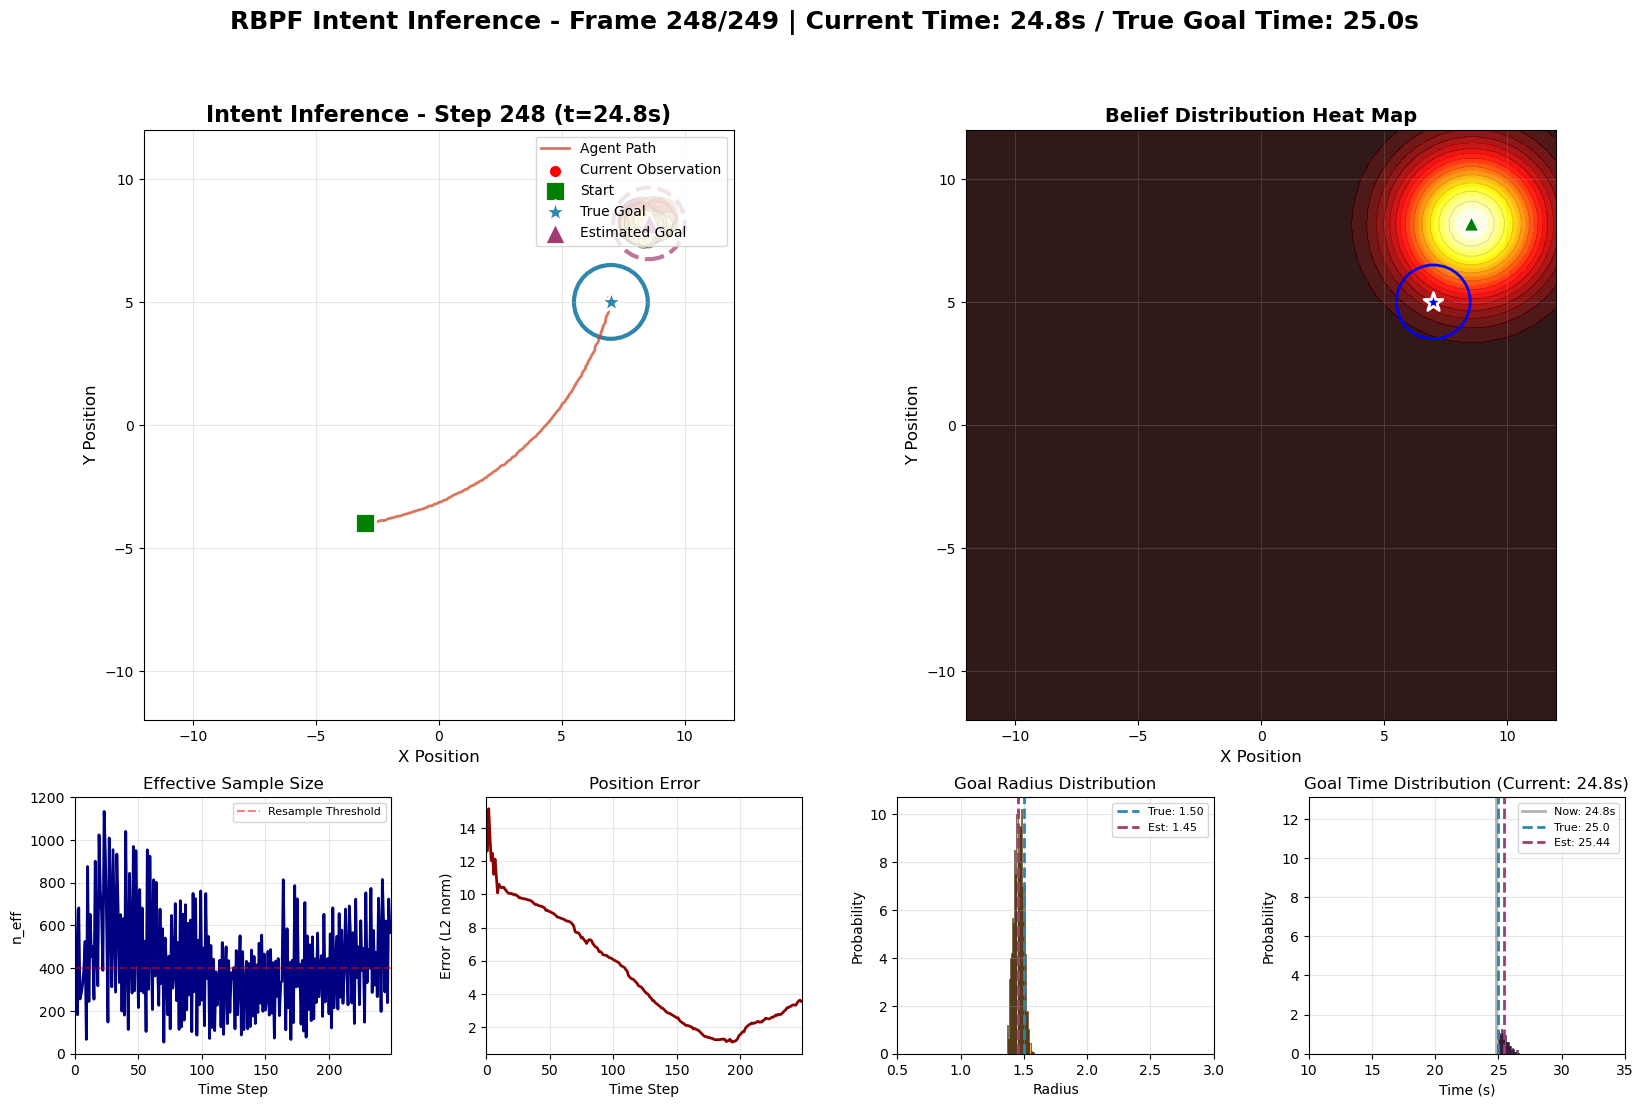


FINAL RESULTS
True Intent:      x=[7. 5.], r=1.50, t=25.0
Final Estimate:   x=[8.54905027 8.19148065], r=1.45, t=25.4
Final Time:       24.9s

Final Errors:
  Position: 3.548
  Radius:   0.046
  Time:     0.442
True Intent: x=[7. 5.], r=1.50, t=25.0
Start Position: [-3. -4.]

Running simulation with detailed tracking...
------------------------------------------------------------
Step  50 | Time:   5.0s | n_eff: 1141
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 2.12,  0.58], r=2.04, t= 27.4
  Error: x= 6.58, r=0.54, t=  2.4
------------------------------------------------------------
Step 100 | Time:  10.0s | n_eff: 1200
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 3.68,  2.02], r=1.93, t= 18.6
  Error: x= 4.46, r=0.43, t=  6.4
------------------------------------------------------------
Step 150 | Time:  15.0s | n_eff: 1200
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 5.64,  3.65], r=1.63, t= 18.5
  Error: x= 1.91, r=0.13, t=  6.5
--------------------

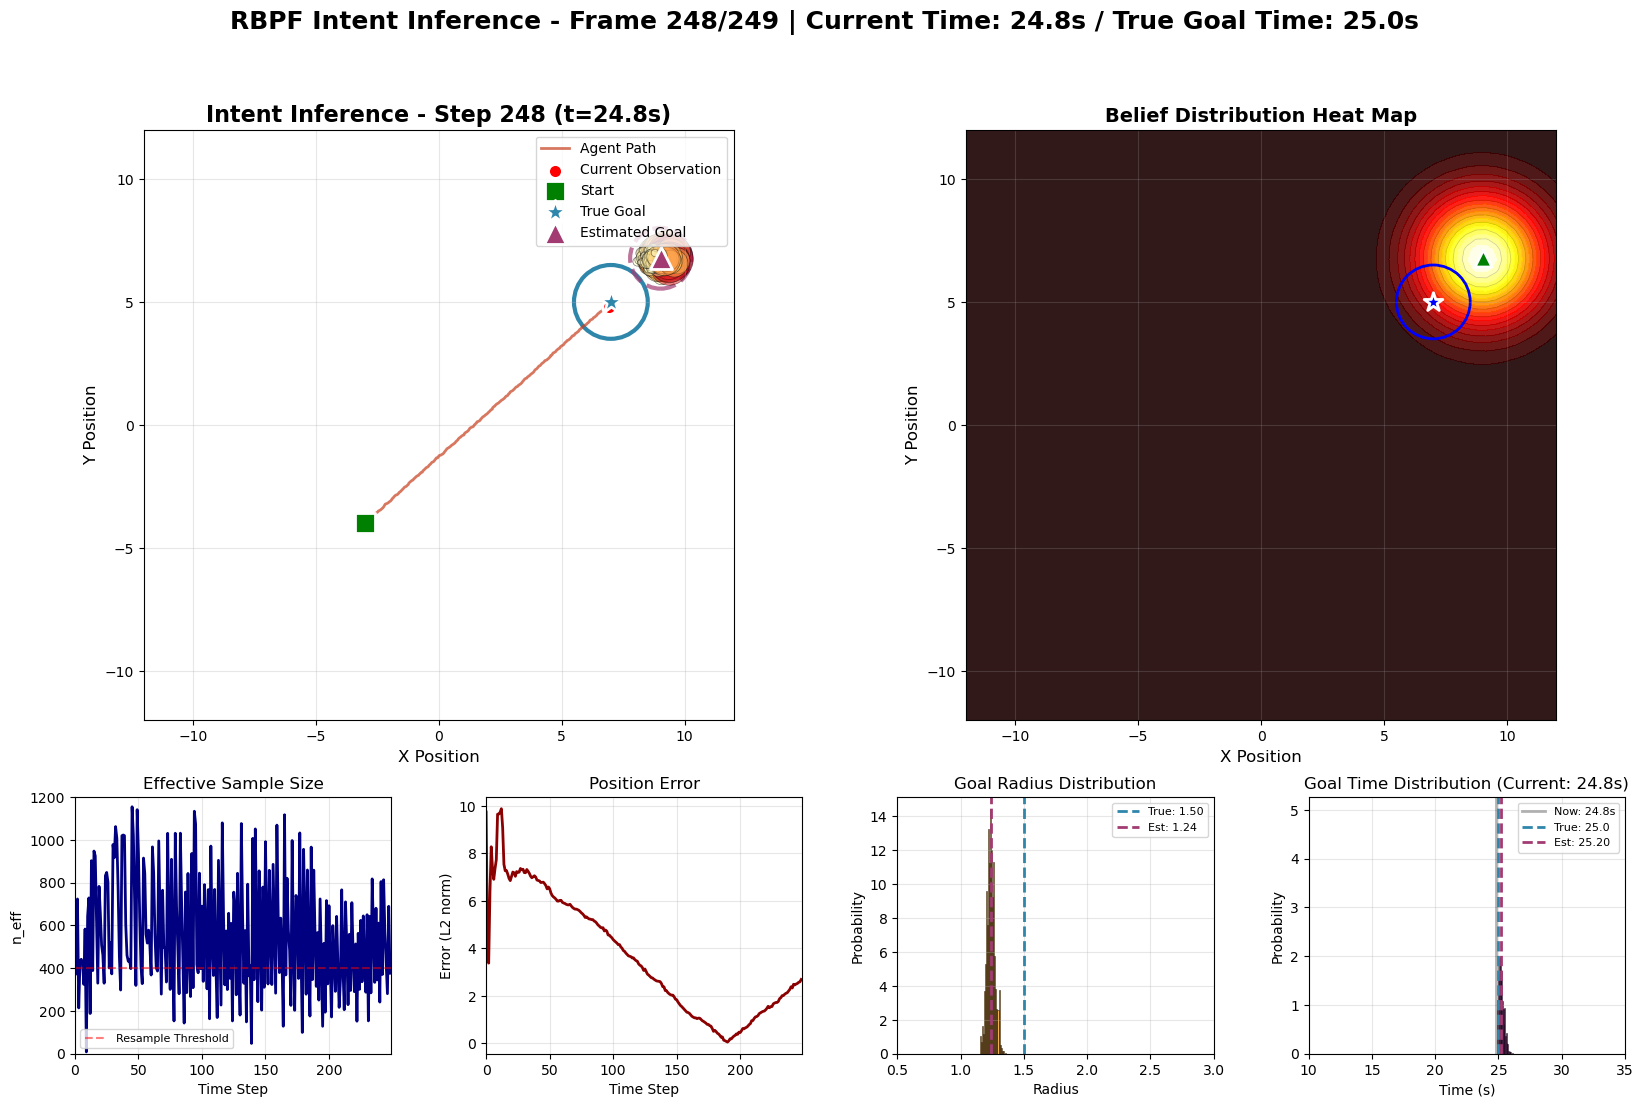


FINAL RESULTS
True Intent:      x=[7. 5.], r=1.50, t=25.0
Final Estimate:   x=[8.97960216 6.76871933], r=1.24, t=25.3
Final Time:       24.9s

Final Errors:
  Position: 2.655
  Radius:   0.262
  Time:     0.256
True Intent: x=[7. 5.], r=1.50, t=25.0
Start Position: [-3. -4.]

Running simulation with detailed tracking...
------------------------------------------------------------
Step  50 | Time:   5.0s | n_eff: 1200
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 4.78,  7.77], r=2.97, t= 21.2
  Error: x= 3.55, r=1.47, t=  3.8
------------------------------------------------------------
Step 100 | Time:  10.0s | n_eff: 1200
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 7.82,  4.37], r=2.96, t= 20.4
  Error: x= 1.03, r=1.46, t=  4.6
------------------------------------------------------------
Step 150 | Time:  15.0s | n_eff: 1200
  True:  x=[ 7.00,  5.00], r=1.50, t= 25.0
  Est:   x=[ 7.10,  4.56], r=2.97, t= 19.9
  Error: x= 0.46, r=1.47, t=  5.1
--------------------

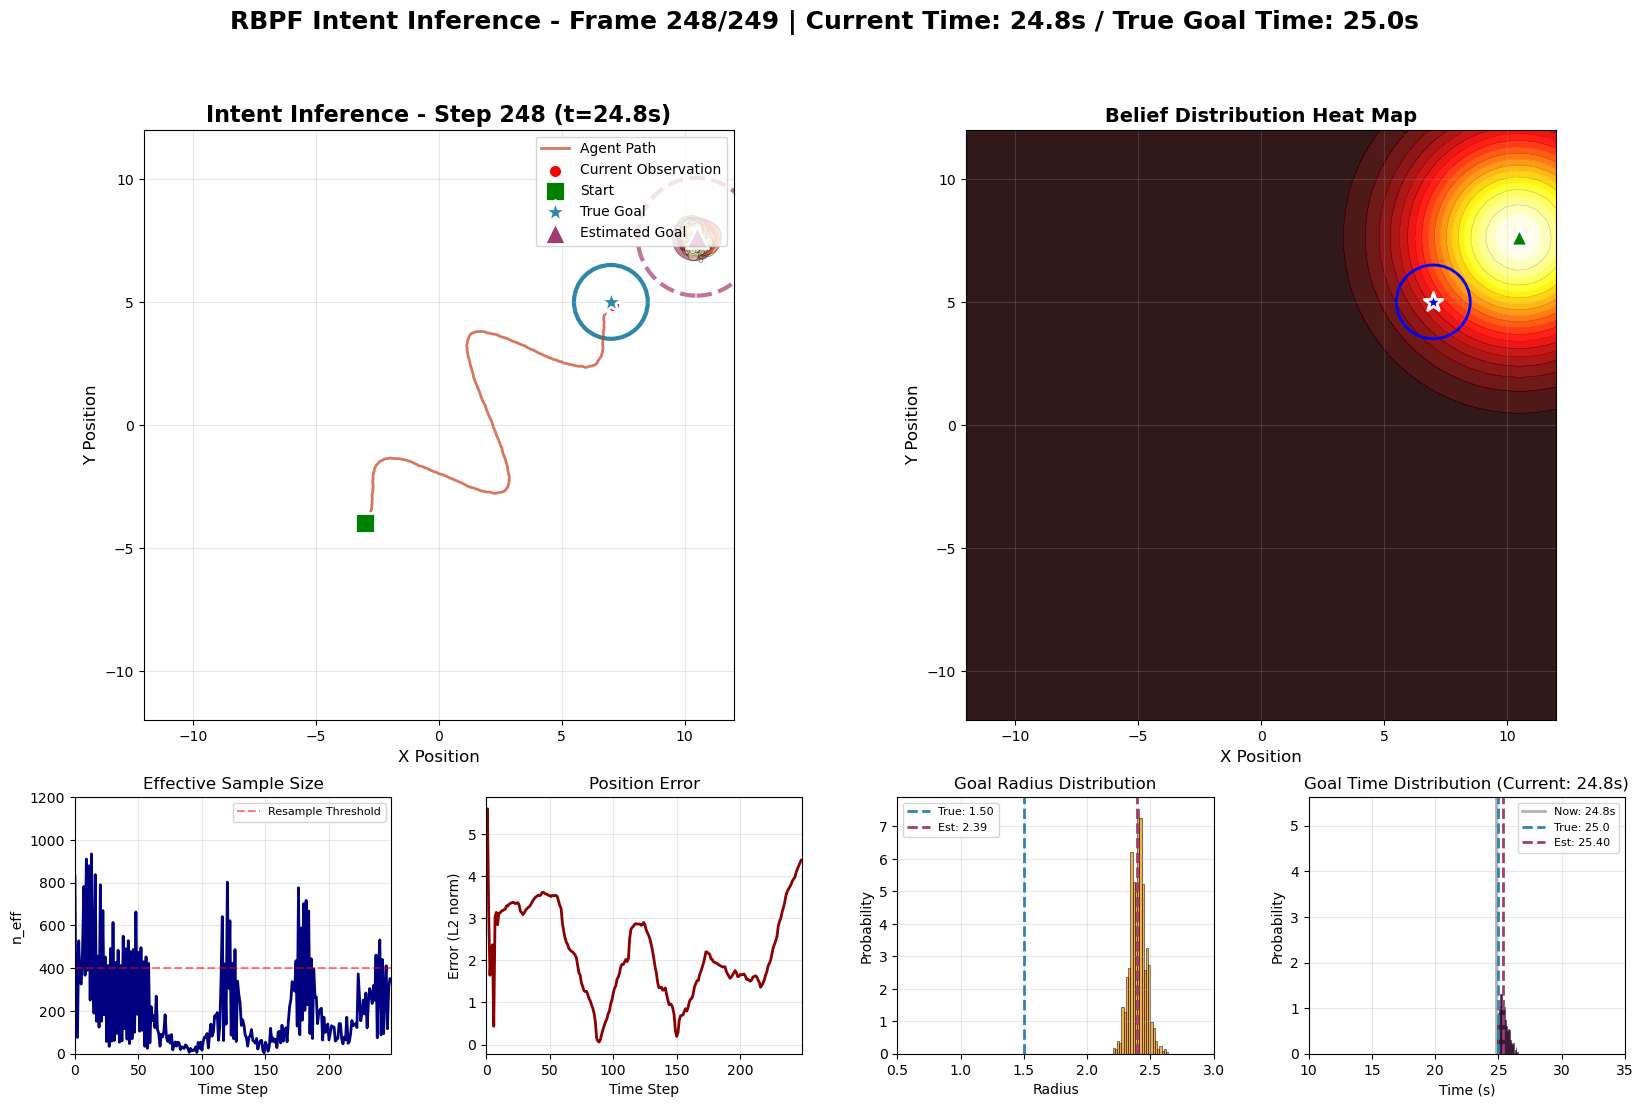


FINAL RESULTS
True Intent:      x=[7. 5.], r=1.50, t=25.0
Final Estimate:   x=[10.46971619  7.62371625], r=2.40, t=25.4
Final Time:       24.9s

Final Errors:
  Position: 4.350
  Radius:   0.901
  Time:     0.420


In [4]:

def create_animated_inference(save_gif=True, save_mp4=False, filename_base='intent_inference', reference_type = 'curve'):
    
    save_folder = 'figures'
    
    # Setup parameters
    theta_true = np.array([7.0, 5.0, 1.5, 25.0])  # [x, y, r, t]
    x0 = np.array([-3.0, -4.0])
    
    print(f"True Intent: x={theta_true[:2]}, r={theta_true[2]:.2f}, t={theta_true[3]:.1f}")
    print(f"Start Position: {x0}")
    
    # Create agent and filter
    #agent = AgentWithIntent(theta_true, x0, d_bar=0.2, dt=0.1)
    agent = MultiModeAgent(theta_com=theta_true, x0=x0, mode=reference_type, amplitude=3.0)
    rbpf = PaperBasedRBPF(N=1200, R=12.0, r_min=0.5, r_max=3.0,
                         t_min=10.0, t_max=35.0, d_bar=0.2, err_std=0.1)
    
    # Run simulation to collect data
    T = 250
    observations = []
    
    print("\nRunning simulation with detailed tracking...")
    print("-" * 60)
    for t in range(T):
        x_true = agent.step()
        y = x_true + np.random.randn(2) * 0.1
        observations.append(y)
        rbpf.update(y)
        
        if t % 50 == 0 and t > 0:
            est = rbpf.get_estimate('reduced')
            print(f"Step {t:3d} | Time: {rbpf.current_time:5.1f}s | n_eff: {rbpf.compute_n_eff():4.0f}")
            print(f"  True:  x=[{theta_true[0]:5.2f}, {theta_true[1]:5.2f}], r={theta_true[2]:4.2f}, t={theta_true[3]:5.1f}")
            print(f"  Est:   x=[{est['x'][0]:5.2f}, {est['x'][1]:5.2f}], r={est['r']:4.2f}, t={est['t']:5.1f}")
            
            # Calculate errors
            err_x = np.linalg.norm(est['x'] - theta_true[:2])
            err_r = abs(est['r'] - theta_true[2])
            err_t = abs(est['t'] - theta_true[3])
            print(f"  Error: x={err_x:5.2f}, r={err_r:4.2f}, t={err_t:5.1f}")
            print("-" * 60)
    
    observations = np.array(observations)
    trajectory = np.array(agent.trajectory)
    
    print("Creating animation...")
    
    # Setup figure with custom layout
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Main plots
    ax_main = fig.add_subplot(gs[:2, :2])  # Large main plot
    ax_heat = fig.add_subplot(gs[:2, 2:])   # Heat map
    
    # Bottom plots
    ax_neff = fig.add_subplot(gs[2, 0])     # n_eff
    ax_error = fig.add_subplot(gs[2, 1])    # Error
    ax_radius = fig.add_subplot(gs[2, 2])   # Radius distribution
    ax_time = fig.add_subplot(gs[2, 3])     # Time distribution
    
    # Color scheme
    colors = {
        'true': '#2E86AB',
        'estimate': '#A23B72',
        'particles': '#F18F01',
        'trajectory': '#C73E1D'
    }
    
    def init():
        """Initialize animation"""
        return []
    
    def animate(frame):
        """Animation function"""
        
        # Clear all axes
        for ax in [ax_main, ax_heat, ax_neff, ax_error, ax_radius, ax_time]:
            ax.clear()
        
        # Skip if no data yet
        if frame >= len(rbpf.history['particles']) or frame == 0:
            return []
        
        # Get current data
        particles = rbpf.history['particles'][frame]
        weights = rbpf.history['weights'][frame]
        n_eff = rbpf.history['n_eff'][frame]
        estimate = rbpf.history['estimates'][frame]
        current_time = frame * 0.1  # Current simulation time
        
        # ========== MAIN PLOT ==========
        ax_main.set_title(f'Intent Inference - Step {frame} (t={current_time:.1f}s)', 
                         fontsize=16, fontweight='bold')
        
        # Plot trajectory up to current time
        ax_main.plot(trajectory[:frame+1, 0], trajectory[:frame+1, 1],
                    color=colors['trajectory'], linewidth=2, alpha=0.7,
                    label='Agent Path')
        
        # Current observation
        ax_main.scatter(observations[frame, 0], observations[frame, 1],
                       c='red', s=100, zorder=5, marker='o',
                       edgecolors='white', linewidth=2,
                       label='Current Observation')
        
        # Start and goal
        ax_main.scatter(x0[0], x0[1], c='green', s=200, marker='s',
                       edgecolors='white', linewidth=2,
                       label='Start', zorder=5)
        ax_main.scatter(theta_true[0], theta_true[1], 
                       color=colors['true'], s=300, marker='*',
                       edgecolors='white', linewidth=2,
                       label='True Goal', zorder=5)
        
        # True goal region
        circle_true = Circle(theta_true[:2], theta_true[2],
                            fill=False, edgecolor=colors['true'], 
                            linewidth=3, linestyle='-')
        ax_main.add_patch(circle_true)
        
        # Estimated goal
        ax_main.scatter(estimate['x'][0], estimate['x'][1],
                       color=colors['estimate'], s=250, marker='^',
                       edgecolors='white', linewidth=2,
                       label='Estimated Goal', zorder=5)
        
        # Estimated goal region
        circle_est = Circle(estimate['x'], estimate['r'],
                           fill=False, edgecolor=colors['estimate'],
                           linewidth=3, linestyle='--', alpha=0.7)
        ax_main.add_patch(circle_est)
        
        # Plot particles (only significant ones)
        mask = weights > 1e-4
        if np.any(mask):
            sizes = 1000 * weights[mask] / np.max(weights[mask])
            ax_main.scatter(particles[mask, 0], particles[mask, 1],
                          c=weights[mask], s=sizes,
                          cmap='YlOrRd', alpha=0.5,
                          edgecolors='black', linewidth=0.5)
        
        ax_main.set_xlim(-rbpf.R, rbpf.R)
        ax_main.set_ylim(-rbpf.R, rbpf.R)
        ax_main.set_xlabel('X Position', fontsize=12)
        ax_main.set_ylabel('Y Position', fontsize=12)
        ax_main.legend(loc='upper right', fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_aspect('equal')
        
        # ========== HEAT MAP ==========
        ax_heat.set_title('Belief Distribution Heat Map', fontsize=14, fontweight='bold')
        
        # Create grid
        resolution = 60
        x_range = np.linspace(-rbpf.R, rbpf.R, resolution)
        y_range = np.linspace(-rbpf.R, rbpf.R, resolution)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.zeros_like(X)
        
        # Accumulate Gaussian contributions
        for i in range(len(particles)):
            if weights[i] > 1e-6:
                x_i, y_i = particles[i, :2]
                r_i = particles[i, 2]
                
                # Gaussian contribution
                contrib = weights[i] * np.exp(
                    -((X - x_i)**2 + (Y - y_i)**2) / (2 * (r_i + 0.5)**2)
                )
                Z += contrib
        
        # Normalize
        if np.max(Z) > 0:
            Z = Z / np.max(Z)
        
        # Plot heat map
        im = ax_heat.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.9)
        ax_heat.contour(X, Y, Z, levels=10, colors='black', alpha=0.2, linewidths=0.5)
        
        # Add true goal
        ax_heat.scatter(theta_true[0], theta_true[1],
                       color='blue', s=200, marker='*',
                       edgecolors='white', linewidth=2, zorder=5)
        circle_true_heat = Circle(theta_true[:2], theta_true[2],
                                fill=False, edgecolor='blue',
                                linewidth=2, linestyle='-')
        ax_heat.add_patch(circle_true_heat)
        
        # Add estimated goal
        ax_heat.scatter(estimate['x'][0], estimate['x'][1],
                       color='green', s=150, marker='^',
                       edgecolors='white', linewidth=2, zorder=5)
        
        ax_heat.set_xlim(-rbpf.R, rbpf.R)
        ax_heat.set_ylim(-rbpf.R, rbpf.R)
        ax_heat.set_xlabel('X Position', fontsize=12)
        ax_heat.set_ylabel('Y Position', fontsize=12)
        ax_heat.set_aspect('equal')
        ax_heat.grid(True, alpha=0.2)
        
        # ========== N_EFF PLOT ==========
        ax_neff.set_title('Effective Sample Size', fontsize=12)
        ax_neff.plot(rbpf.history['n_eff'][:frame+1], 
                    color='navy', linewidth=2)
        ax_neff.axhline(rbpf.N/3, color='red', linestyle='--', 
                       alpha=0.5, label='Resample Threshold')
        ax_neff.set_xlabel('Time Step')
        ax_neff.set_ylabel('n_eff')
        ax_neff.set_xlim(0, len(rbpf.history['n_eff']))
        ax_neff.set_ylim(0, rbpf.N)
        ax_neff.grid(True, alpha=0.3)
        ax_neff.legend(fontsize=8)
        
        # ========== ERROR PLOT ==========
        ax_error.set_title('Position Error', fontsize=12)
        
        # Calculate errors over time
        errors = []
        for est in rbpf.history['estimates'][:frame+1]:
            err = np.linalg.norm(est['x'] - theta_true[:2])
            errors.append(err)
        
        ax_error.plot(errors, color='darkred', linewidth=2)
        ax_error.set_xlabel('Time Step')
        ax_error.set_ylabel('Error (L2 norm)')
        ax_error.set_xlim(0, len(rbpf.history['n_eff']))
        ax_error.grid(True, alpha=0.3)
        
        # ========== RADIUS DISTRIBUTION ==========
        ax_radius.set_title('Goal Radius Distribution', fontsize=12)
        ax_radius.hist(particles[:, 2], weights=weights, bins=25,
                      alpha=0.7, color=colors['particles'], density=True,
                      edgecolor='black', linewidth=0.5)
        ax_radius.axvline(theta_true[2], color=colors['true'],
                         linestyle='--', linewidth=2,
                         label=f'True: {theta_true[2]:.2f}')
        ax_radius.axvline(estimate['r'], color=colors['estimate'],
                         linestyle='--', linewidth=2,
                         label=f'Est: {estimate["r"]:.2f}')
        ax_radius.set_xlabel('Radius')
        ax_radius.set_ylabel('Probability')
        ax_radius.set_xlim(rbpf.r_min, rbpf.r_max)
        ax_radius.legend(fontsize=8)
        ax_radius.grid(True, alpha=0.3)
        
        # ========== TIME DISTRIBUTION ==========
        ax_time.set_title(f'Goal Time Distribution (Current: {current_time:.1f}s)', 
                         fontsize=12)
        
        # Filter out particles with invalid times (less than current time)
        valid_times = particles[:, 3]
        valid_weights = weights.copy()
        
        # Highlight current time
        ax_time.axvline(current_time, color='black', linestyle='-', 
                       linewidth=2, alpha=0.3, label=f'Now: {current_time:.1f}s')
        
        ax_time.hist(valid_times, weights=valid_weights, bins=25,
                    alpha=0.7, color='purple', density=True,
                    edgecolor='black', linewidth=0.5)
        ax_time.axvline(theta_true[3], color=colors['true'],
                       linestyle='--', linewidth=2,
                       label=f'True: {theta_true[3]:.1f}')
        ax_time.axvline(estimate['t'], color=colors['estimate'],
                       linestyle='--', linewidth=2,
                       label=f'Est: {estimate["t"]:.2f}')
        ax_time.set_xlabel('Time (s)')
        ax_time.set_ylabel('Probability')
        ax_time.set_xlim(rbpf.t_min, rbpf.t_max)
        ax_time.legend(fontsize=8)
        ax_time.grid(True, alpha=0.3)
        
        # Add frame counter
        fig.suptitle(f'RBPF Intent Inference - Frame {frame}/{len(rbpf.history["particles"])} | '
                    f'Current Time: {current_time:.1f}s / True Goal Time: {theta_true[3]:.1f}s',
                    fontsize=18, fontweight='bold', y=0.98)
        
        return []
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(rbpf.history['particles']),
                                 interval=50, blit=False)
    
    # Save animation
    if save_gif:
        print(f"Saving animation as {save_folder}/{filename_base + reference_type}.gif...")
        anim.save(f'{save_folder}/{filename_base + reference_type}.gif', writer='pillow', fps=20)
        print(f"Animation saved as {save_folder}/{filename_base + reference_type}.gif")
    
    if save_mp4:
        print(f"Saving animation as {save_folder}/{filename_base + reference_type}.mp4...")
        try:
            anim.save(f'{save_folder}/{filename_base + reference_type}.mp4', writer='ffmpeg', fps=20, 
                     bitrate=2000, codec='libx264')
            print(f"Animation saved as {save_folder}/{filename_base + reference_type}.mp4")
        except:
            print("MP4 save failed. Make sure ffmpeg is installed.")
    
    plt.show()
    
    # Print final results
    print("\n" + "=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    
    final_estimate = rbpf.get_estimate('reduced')
    print(f"True Intent:      x={theta_true[:2]}, r={theta_true[2]:.2f}, t={theta_true[3]:.1f}")
    print(f"Final Estimate:   x={final_estimate['x']}, r={final_estimate['r']:.2f}, t={final_estimate['t']:.1f}")
    print(f"Final Time:       {rbpf.current_time:.1f}s")
    
    # Calculate final errors
    err_x = np.linalg.norm(final_estimate['x'] - theta_true[:2])
    err_r = abs(final_estimate['r'] - theta_true[2])
    err_t = abs(final_estimate['t'] - theta_true[3])
    
    print(f"\nFinal Errors:")
    print(f"  Position: {err_x:.3f}")
    print(f"  Radius:   {err_r:.3f}")
    print(f"  Time:     {err_t:.3f}")
    
    print("=" * 60)
    
    return anim, rbpf


if __name__ == "__main__":
    # Create and save animation
    for reference_type in ['curve', 'line', 'sinusoid']:
        anim, rbpf = create_animated_inference(
            save_gif=True,      # Save as GIF
            save_mp4=False,     # Save as MP4 (requires ffmpeg)
            filename_base='rbpf_intent_inference_',
            reference_type=reference_type
        )